# Differentiable numerical simulations

Both backends (``torch`` and ``jax``) naturally provide high computational performance based on just-in-time compiled kernels and end-to-end gradient-based parameter learning through automatic differentiation. This enables inverse material design where you start from a desired outcome (material behaviour or time evolution of a system) and work your way backwards to the input parameters which lead to this desired output.
Generally, the integration of high-resolution imaging with predictive simulations and data‐driven optimization holds promise to accelerate discovery and to deepen our understanding of process–structure–property relationships.

Some general information about differentiable physics can be found [here](https://physicsbaseddeeplearning.org/diffphys.html).

In the following example we build a physics-informed parameter estimation pipeline using differentiable simulation. The physical system is governed by the Cahn–Hilliard equation, a nonlinear fourth-order PDE modeling phase separation and coarsening in materials. It depends on two key parameters:
- $D$ (mobility or diffusivity),
- $\epsilon$ (controls interface thickness and energy).

We assume that the initial condition $c_0(x)$ is known.
A set of partial observations of the field $c(x,t)$ at specific time steps $t_i$ is given.
The goal is to find the physical parameters ($D$, $\epsilon$) that best reproduce the observed dynamics of $c(x,t)$ across multiple sequences of the system's evolution.

This is done by:
1. Simulating forward with guessed parameters to compute $c_\text{sim}(x, t_i)$.
2. Computing residuals: difference between simulation and measurement.
3. Optimizing parameters: via Levenberg–Marquardt (a trust-region variant of Gauss–Newton least-squares).

Mathematically this can be expressed as

$$\min_\theta \sum_j^{N_\text{sequences}}\sum_i^{T} ||c_\text{measured}^{(j)}(t_i)−c_\text{sim}^{(j)}(t_i, \theta)||_2^2​$$

with the state variables $\theta = (D, \epsilon)$.

In [1]:
import voxelsss as vox
import numpy as np

In [2]:
Nx, Ny, Nz = [100, 100, 100]
vf = vox.VoxelFields((Nx, Ny, Nz), domain_size=(Nx, Ny, Nz))
noise = 0.5 + 0.1*(0.5-np.random.rand(Nx, Ny, Nz))
vf.add_field('c', noise)

We create an `InversionModel` for the ``PeriodicCahnHilliard`` problem which sets up the voxel grid and the parameters of the PDE.

In [3]:
from voxelsss.problem_definition import PeriodicCahnHilliard
fixed_problem_kwargs={"mu_hom": None}
pos_params = ["D", "eps"]
model = vox.InversionModel(vf, PeriodicCahnHilliard, pos_params, fixed_problem_kwargs)

### Choose output times

``diffrax.SaveAt`` specifies at which time points the solver should store the concentration field. These will later be used as training data.

In [4]:
import diffrax as dfx
saveat = dfx.SaveAt(ts=np.linspace(0, 100, 11))

In [5]:
res = model.forward_solve({"D": 1.0, "eps": 3.0}, 'c', saveat, dt0=1)

Wall time: 7.0115 s after 100 iterations (0.0701 s/iter)
GPU-RAM nvidia-smi current:  34648 MB (34648 MB max)


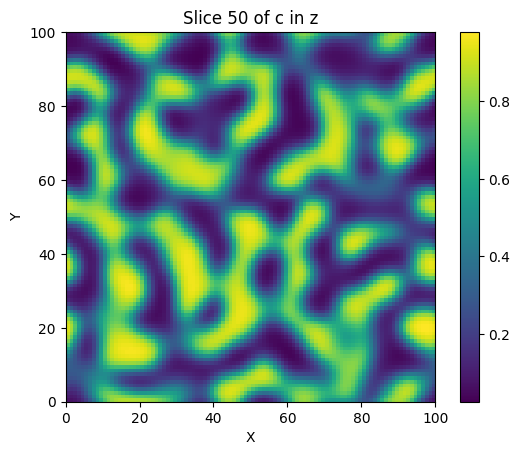

In [6]:
vf.plot_slice('c', Nz//2)

Next, the solver output is organised into a small dictionary containing the sampled states `ys` and their time stamps `ts`. The index list `inds` selects which time steps form each training sequence.

In [7]:
data = {}
data["ts"] = saveat.subs.ts
data["ys"] = res

inds = [[1,2,3], [4,5,6], [7,8,9]]

### Run the optimisation

The `train` method performs a Levenberg–Marquardt least-squares fit of the parameters $D$ and $\epsilon$ so that the simulated states match the selected measurements.

In [8]:
tmp = model.train({"D": np.array([2.0]), "eps": np.array([2.0])}, data, inds, max_steps=50)

Step: 0, Accepted steps: 0, Steps since acceptance: 0, Loss on this step: 161394.859375, Loss on the last accepted step: 0.0, Step size: 1.0
Step: 1, Accepted steps: 1, Steps since acceptance: 0, Loss on this step: 32180.85546875, Loss on the last accepted step: 161394.859375, Step size: 3.5
Step: 2, Accepted steps: 2, Steps since acceptance: 0, Loss on this step: 4989.21484375, Loss on the last accepted step: 32180.85546875, Step size: 12.25
Step: 3, Accepted steps: 3, Steps since acceptance: 0, Loss on this step: 97.1269302368164, Loss on the last accepted step: 4989.21484375, Step size: 42.875
Step: 4, Accepted steps: 4, Steps since acceptance: 0, Loss on this step: 26.665313720703125, Loss on the last accepted step: 97.1269302368164, Step size: 42.875
Step: 5, Accepted steps: 5, Steps since acceptance: 0, Loss on this step: 26.624557495117188, Loss on the last accepted step: 26.665313720703125, Step size: 150.0625
Step: 6, Accepted steps: 6, Steps since acceptance: 0, Loss on this 

The converged values from the physics-informed parameter estimation should be close to the 'true' values of $D=1$ and $\epsilon=3$. Even with the very small synthetic dataset used here the optimiser quickly converges.

In [9]:
print(f"Estimated D = {tmp['D']},")
print(f"Estimated eps = {tmp['eps']}.")

Estimated D = [0.9226131],
Estimated eps = [3.012685].
